*Welcome to Jina !*
In this notebook, we will show 2 different use cases you can achieve with Jina framework:
* Building AI services: French to English translation service with `mbart` model
* Building AI pipelines: we will combine the translation service with a Stable Diffusion image generation service. We will end up with a French Text to Image generation service !

## Building AI services: French to English Translator

Let us start by installing dependencies

In [ ]:
!pip install git+https://github.com/jina-ai/jina.git@master transformers sentencepiece torch

Implement the translation service using Executor

In [ ]:
from jina import Executor, requests, DocumentArray
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM


class FrenchToEnglishTranslator(Executor):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.tokenizer = AutoTokenizer.from_pretrained("facebook/mbart-large-50-many-to-many-mmt", src_lang="fr_XX")
        self.model = AutoModelForSeq2SeqLM.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")

    @requests
    def translate(self, docs: DocumentArray, **kwargs):
        for doc in docs:
            doc.text = self._translate(doc.text)

    def _translate(self, text):
        encoded_en = self.tokenizer(text, return_tensors="pt")
        generated_tokens = self.model.generate(**encoded_en, forced_bos_token_id=self.tokenizer.lang_code_to_id["en_XX"])
        return self.tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)[0]


Then, Run the translation service using `Deployment`.
The service uses gRPC and `Deployment` can be used as a client to submit requests to the service:

In [ ]:
from jina import Deployment, Document
with Deployment(uses=FrenchToEnglishTranslator, timeout_ready=-1) as dep:
  docs = dep.post(on='/', inputs=[Document(text='un astronaut est en train de faire une promenade dans un parc')])
  print(docs[0].text)

──────────────────────────────────────── 🎉 Deployment is ready to serve! ─────────────────────────────────────────
╭────────────── 🔗 Endpoint ───────────────╮
│  ⛓      Protocol                   GRPC  │
│  🏠        Local          ]8;id=568498;grpc://0.0.0.0:64980\0.0.0.0]8;;\]8;id=941366;grpc://0.0.0.0:64980\:]8;;\]8;id=533239;grpc://0.0.0.0:64980\64980]8;;\  │
│  🔒      Private      ]8;id=44565;grpc://172.28.0.12:64980\172.28.0.12]8;;\]8;id=738451;grpc://172.28.0.12:64980\:]8;;\]8;id=833824;grpc://172.28.0.12:64980\64980]8;;\  │
│  🌍       Public    ]8;id=49127;grpc://34.87.172.234:64980\34.87.172.234]8;;\]8;id=953364;grpc://34.87.172.234:64980\:]8;;\]8;id=29262;grpc://34.87.172.234:64980\64980]8;;\  │
╰──────────────────────────────────────────╯

an astronaut is walking in a park


## Building AI Pipelines: French Text to Image Generation

Install dependencies:

In [ ]:
!pip install git+https://github.com/jina-ai/jina.git@master diffusers accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/jina-ai/jina.git (to revision master) to /tmp/pip-req-build-dfmt_gdt
  Running command git clone --filter=blob:none --quiet https://github.com/jina-ai/jina.git /tmp/pip-req-build-dfmt_gdt
  Resolved https://github.com/jina-ai/jina.git to commit 18e5e53291853eb876169b8b4187613623162a02
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 604.0/604.0 KB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 27.8 MB/s eta 0:00:00


We can use the `diffusers` library to implement another Text to Image generation service (based on Stable Diffusion) using `Executor`.
Note that Stable Diffusion only understand English queries. Therefore, combining it with the French to English Translation service will allow it to support French as well.

In [ ]:
import numpy as np
from jina import Executor, requests, DocumentArray


class TextToImage(Executor):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        from diffusers import StableDiffusionPipeline
        import torch
        self.pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16).to("cuda")

    @requests
    def generate_image(self, docs: DocumentArray, **kwargs):
        images = self.pipe(docs.texts).images  # image here is in [PIL format](https://pillow.readthedocs.io/en/stable/)
        for i, doc in enumerate(docs):
            doc.tensor = np.array(images[i])

Now we can combine both services into a pipeline using `Flow`:

In [ ]:
from jina import Flow, Document

flow = Flow(port=12345).add(uses=FrenchToEnglishTranslator, timeout_ready=-1).add(uses=TextToImage, timeout_ready=-1)

with flow:
  docs = flow.post(on='/', inputs=[Document(text='un astronaut est en train de faire une promenade dans un parc')])
  docs[0].display

Alternatively, we can use [the Text to Image Generation Executor from Jina Hub](https://cloud.jina.ai/executor/15jzcmam):

Output()

Output()

─────────────────────────────────────────── 🎉 Flow is ready to serve! ────────────────────────────────────────────
╭────────────── 🔗 Endpoint ───────────────╮
│  ⛓      Protocol                   GRPC  │
│  🏠        Local          ]8;id=745723;grpc://0.0.0.0:12345\0.0.0.0]8;;\]8;id=204519;grpc://0.0.0.0:12345\:]8;;\]8;id=190590;grpc://0.0.0.0:12345\12345]8;;\  │
│  🔒      Private      ]8;id=855819;grpc://172.28.0.12:12345\172.28.0.12]8;;\]8;id=295894;grpc://172.28.0.12:12345\:]8;;\]8;id=830362;grpc://172.28.0.12:12345\12345]8;;\  │
│  🌍       Public    ]8;id=780881;grpc://34.68.165.134:12345\34.68.165.134]8;;\]8;id=900029;grpc://34.68.165.134:12345\:]8;;\]8;id=660476;grpc://34.68.165.134:12345\12345]8;;\  │
╰──────────────────────────────────────────╯

Do you love Open Source? Help us get better and be heard in just 1 minute and 30 seconds 💖Your feedback will help 
us build better features for ]8;id=622181;https://github.com/jina-ai/jina\Jina]8;;\, your loved open-source project 🎉 
https://10sw1tcpld4.typeform.com/jinasurveyfeb23?utm_source=jina Take the Jina user survey!

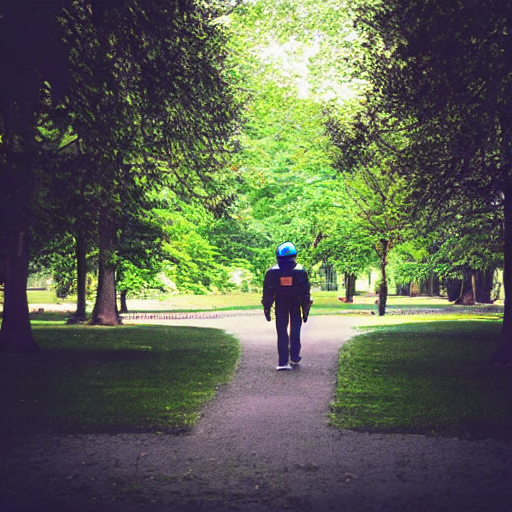

In [ ]:
from jina import Flow, Document

flow = Flow(port=12345).add(uses=FrenchToEnglishTranslator, timeout_ready=-1).add(uses='jinaai://alaeddineabdessalem/TextToImage', timeout_ready=-1, install_requirements=True)

with flow:
  docs = flow.post(on='/', inputs=[Document(text='un astronaut est en train de faire une promenade dans un parc')])
  docs[0].display()